# MRMR: multiresolution multi-robot visualization

Code for the visual analysis of an experiment for this paper. It is assumed that the experiments had been run with nRobot1Day-Run. 

This notebook creates the specific type of visualizations for this paper. 

In [ ]:
import sys
sys.path.append("../..")
from exp_run_config import Config
Config.PROJECTNAME = "WaterBerryFarms"
import pathlib
from pprint import pprint
import gzip as compress
import pickle

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# import matplotlib
import numpy as np

from information_model import StoredObservationIM

import wbf_figures

In [5]:
# the experiment for the robot run
experiment = "mrmr"

# run = "mrmr-3random"
# run = "mrmr-3lawnmowers"
# run = "mrmr-1pioneer-2contractors"
# run = "mrmr-clustered-1pio-2con"
run = "mrmr-clustered-3lawnmowers"

exp = Config().get_experiment(experiment, run)
pprint(exp)

resultsfile = pathlib.Path(exp["data_dir"], "results.pickle")
if not resultsfile.exists():
    print(f"Results file does not exist:\n{resultsfile}")
    print("Run the notebook Run-1Robot1Day with the same exp/run to create it.")
    raise Exception("Nothing to do.")

# load the results file
with compress.open(resultsfile, "rb") as f:
    results = pickle.load(f)

***ExpRun**: No system dependent experiment file
	 G:\My Drive\LotziStudy\Code\PackageTracking\WaterBerryFarms\settings\experiment-config\LotziYoga\mrmr\mrmr-clustered-3lawnmowers_sysdep.yaml,
	 that is ok, proceeding.
***ExpRun**: Configuration for exp/run: mrmr/mrmr-clustered-3lawnmowers successfully loaded
Experiment: {'velocity': 1, 'timesteps-per-day': 500, 'time-start-environment': 15, 'im_resolution': 10, 'experiment_name': 'mrmr', 'name': '3 lawnmowers', 'exp_environment': 'mrmr-custom-clustered', 'exp_estimator': 'adaptive-disk', 'exp_score': 'weighted_asymmetric', 'robots': [{'name': 'robot-1', 'exp-policy': 'fixed-budget-lawnmower', 'exp-policy-extra-parameters': {'area': '[5, 5, 95, 30]', 'policy-name': 'lawn-bottom'}}, {'name': 'robot-2', 'exp-policy': 'fixed-budget-lawnmower', 'exp-policy-extra-parameters': {'area': '[5, 35, 95, 60]', 'policy-name': 'lawn-middle'}}, {'name': 'robot-3', 'exp-policy': 'fixed-budget-lawnmower', 'exp-policy-extra-parameters': {'area': '[5, 65

### Map with detections
Creates a graph which shows the tylcv ground truth, the robot path and the detections. 

FIXME: we will need to deal with the multiple detections and priority etc.

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 27 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'E', 'L', 'T', 'V', 'Y', 'b', 'eight', 'five', 'four', 'hyphen', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 'seven', 'six', 'space', 't', 'three', 'two', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 38, 40, 47, 55, 57, 60, 69, 81, 82, 85, 87, 89]
INFO:fontTools.subset:Closed glyph list over 'MATH': 27 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'E', 'L', 'T', 'V', 'Y', 'b', 'eight', 'five', 'f

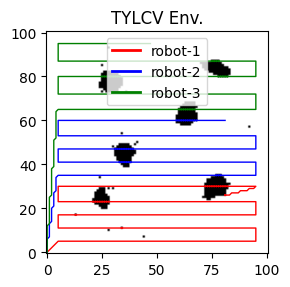

In [ ]:


ROBOT_COLORS = ["red", "blue", "green"]
fig, ax = plt.subplots(1,1, figsize=(3, 3))
wbf_figures.show_env_tylcv(results, ax)

custom_lines = []
labels = []

for i, robot in enumerate(results["robots"]):
    color = ROBOT_COLORS[i % len(results["robots"])]
    observations = [o[i] for o in results["observations"]]
    wbf_figures.show_individual_robot_path(results, ax, robot=robot, observations=observations, pathcolor=color, draw_robot=False)
    wbf_figures.show_individual_robot_detections(results, ax, robotno=i, detection_color=color, radius=0.5)
    # adding to the legend
    custom_lines.append(Line2D([0], [0], color=color, lw=2))
    labels.append(robot.name)


# Add both automatic and manual entries to the legend
ax.legend(handles=[*custom_lines],
          labels=labels)    

plt.savefig(pathlib.Path(exp.data_dir(), "detections-map.pdf"))

### Graph with detections

Count the detections on an agent by agent basis, and create a plot for each of the agents and a sum. 

In [7]:
def count_detections(results, robotno, field = "TYLCV"):
    """Returns the number of detections for the specified robot, adapted from wbf_figures.show_detections"""
    obs = np.array(results["observations"])[:, robotno]
    detections = [[a[StoredObservationIM.X], a[StoredObservationIM.Y]] for a in obs if a[field][StoredObservationIM.VALUE] == 0.0]
    return len(detections)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 20 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'T', 'a', 'b', 'five', 'four', 'hyphen', 'l', 'nonmarkingreturn', 'o', 'one', 'r', 'seven', 'six', 'space', 't', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 23, 24, 25, 26, 55, 68, 69, 79, 82, 85, 87]
INFO:fontTools.subset:Closed glyph list over 'MATH': 20 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'T', 'a', 'b', 'five', 'four', 'hyphen', 'l', 'nonmarkingreturn', 'o', 'one', 'r', 'seven', 'six', 'space', 't', 'three', 'two

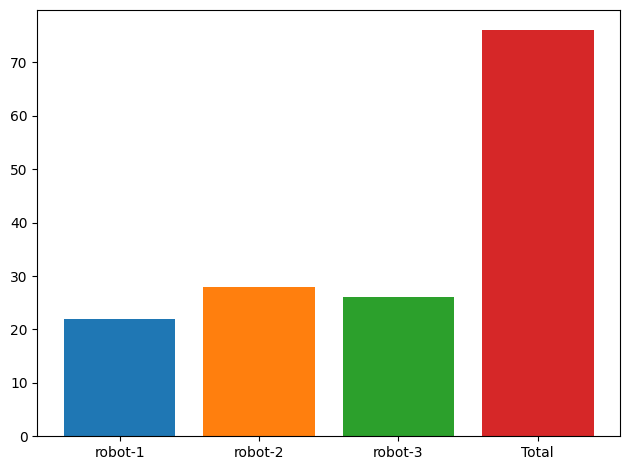

In [8]:
fig, ax = plt.subplots(1,1)
total = 0
for i, robot in enumerate(results["robots"]):
    detections = count_detections(results, i)
    total += detections
    br = ax.bar(robot.name, detections)
ax.bar("Total", total)
plt.savefig(pathlib.Path(exp["data_dir"], "detections-bar.pdf"))